In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# Load the dataset
heart_df = pd.read_csv('heart.csv')

# Display the first few rows of the dataset
heart_df.head()


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [3]:
# Check for missing values
missing_values = heart_df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [5]:
# Define the categorical and numerical columns
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Separate features and target
X = heart_df.drop('HeartDisease', axis=1)
y = heart_df['HeartDisease']

# Apply the preprocessing pipeline to the features
X_preprocessed = preprocessor.fit_transform(X)


In [7]:
# Apply the preprocessing pipeline to the features and convert to DataFrame for better visualization
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

# Display the first few rows of the preprocessed data
print("First few rows of the preprocessed data:\n", X_preprocessed_df.head())


First few rows of the preprocessed data:
    num__Age  num__RestingBP  num__Cholesterol  num__FastingBS  num__MaxHR  \
0 -1.433140        0.410909          0.825070       -0.551341    1.382928   
1 -0.478484        1.491752         -0.171961       -0.551341    0.754157   
2 -1.751359       -0.129513          0.770188       -0.551341   -1.525138   
3 -0.584556        0.302825          0.139040       -0.551341   -1.132156   
4  0.051881        0.951331         -0.034755       -0.551341   -0.581981   

   num__Oldpeak  cat__Sex_F  cat__Sex_M  cat__ChestPainType_ASY  \
0     -0.832432         0.0         1.0                     0.0   
1      0.105664         1.0         0.0                     0.0   
2     -0.832432         0.0         1.0                     0.0   
3      0.574711         1.0         0.0                     1.0   
4     -0.832432         0.0         1.0                     0.0   

   cat__ChestPainType_ATA  cat__ChestPainType_NAP  cat__ChestPainType_TA  \
0               

Class distribution (%):
 HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64


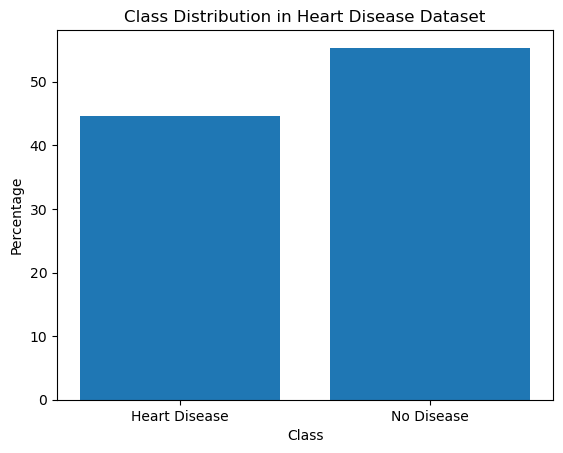

In [9]:
# Check the class distribution of the target variable
class_distribution = y.value_counts(normalize=True) * 100
print("Class distribution (%):\n", class_distribution)

# Visualize the class distribution
plt.bar(class_distribution.index, class_distribution.values, tick_label=['No Disease', 'Heart Disease'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution in Heart Disease Dataset')
plt.show()


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# Define the hyperparameter space for RandomizedSearchCV
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [3000],
}

# Initialize the MLPClassifier
mlp = MLPClassifier(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    mlp, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=2
)


In [16]:
# Fit the random search on the training data
random_search.fit(X_train, y_train)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'solver': 'sgd', 'max_iter': 3000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'relu'}


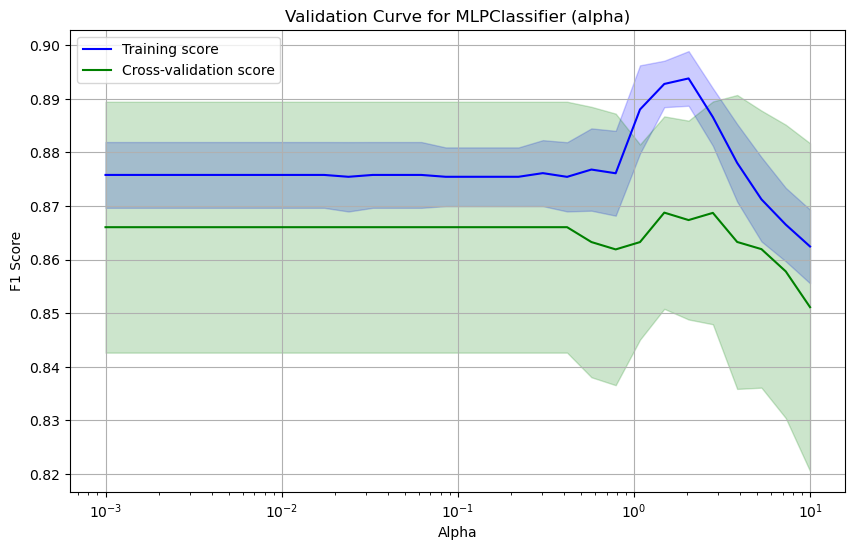

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer, f1_score

# Define the parameter range for alpha
alpha_range = np.logspace(-3, 1, 30)

# Create a scorer for F1 Score
f1_scorer = make_scorer(f1_score, average='weighted')

# Validation curve for alpha
train_scores, valid_scores = validation_curve(
    MLPClassifier(solver='sgd', max_iter=2500, learning_rate='constant', hidden_layer_sizes=(100, 50), activation='relu', random_state=42),
    X_train, y_train,
    param_name='alpha',
    param_range=alpha_range,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, train_mean, label='Training score', color='blue')
plt.plot(alpha_range, valid_mean, label='Cross-validation score', color='green')
plt.fill_between(alpha_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(alpha_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='green')
plt.xscale('log')
plt.title('Validation Curve for MLPClassifier (alpha)')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant, max_iter=3000, solver=adam; total time=   1.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=3000, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=3000, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, max_iter=3000, solver=adam; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=3000, solver=adam; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, max_iter=3000, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(150,), learning_rate=constant, max_iter=3000, solver=adam; total time=   1.8s
[CV] END activation=tanh,

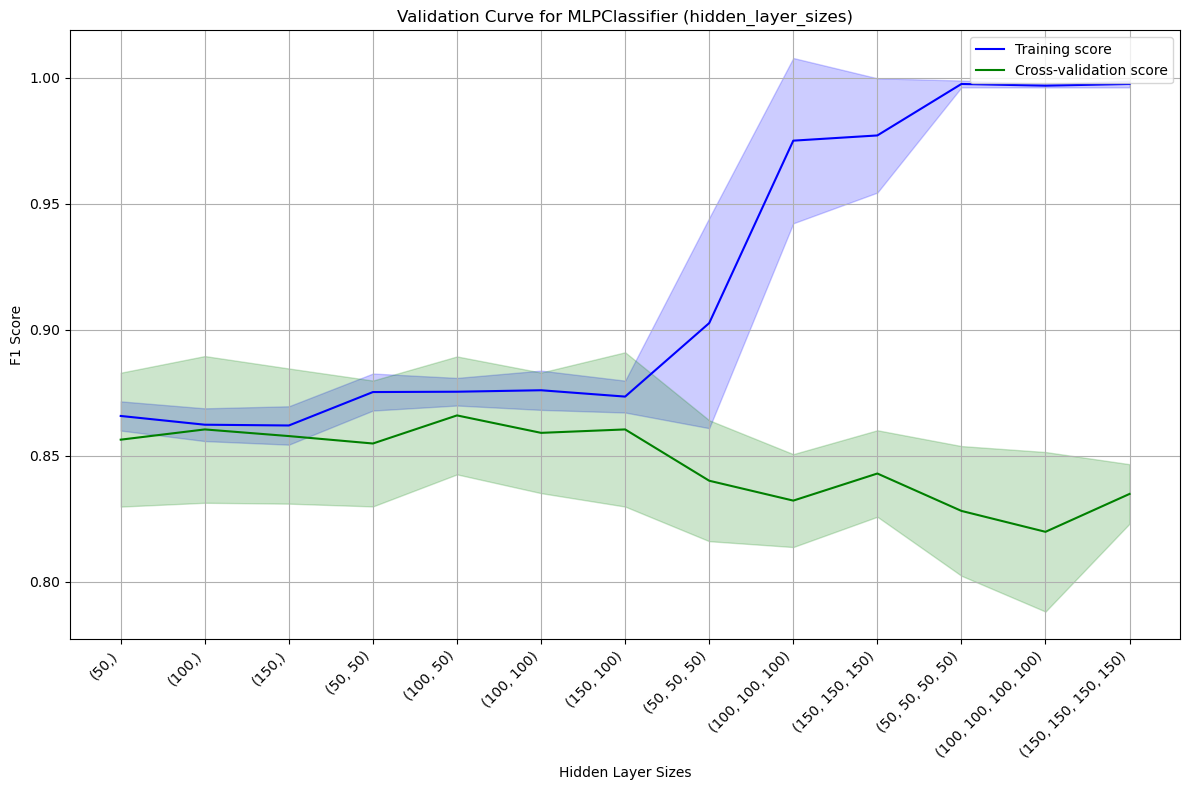

In [20]:
# Define the parameter range for hidden_layer_sizes
hidden_layer_sizes_range = [
    (50,), (100,), (150,), 
    (50, 50), (100, 50), (100, 100), (150, 100), 
    (50, 50, 50), (100, 100, 100), (150, 150, 150), 
    (50, 50, 50, 50), (100, 100, 100, 100), (150, 150, 150, 150)
]
hidden_layer_sizes_labels = [str(hls) for hls in hidden_layer_sizes_range]

# Create a scorer for F1 Score
f1_scorer = make_scorer(f1_score, average='weighted')

# Validation curve for hidden_layer_sizes
train_scores, valid_scores = validation_curve(
    MLPClassifier(solver='sgd', max_iter=4000, learning_rate='constant', alpha=0.1, activation='relu', random_state=42, verbose=True),
    X_train, y_train,
    param_name='hidden_layer_sizes',
    param_range=hidden_layer_sizes_range,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(12, 8))
plt.plot(range(len(hidden_layer_sizes_range)), train_mean, label='Training score', color='blue')
plt.plot(range(len(hidden_layer_sizes_range)), valid_mean, label='Cross-validation score', color='green')
plt.fill_between(range(len(hidden_layer_sizes_range)), train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(range(len(hidden_layer_sizes_range)), valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='green')
plt.xticks(range(len(hidden_layer_sizes_labels)), hidden_layer_sizes_labels, rotation=45, ha='right')
plt.title('Validation Curve for MLPClassifier (hidden_layer_sizes)')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Iteration 1894, loss = 0.20321455
Iteration 1895, loss = 0.20308355
Iteration 1896, loss = 0.20296931
Iteration 1897, loss = 0.20295865
Iteration 1898, loss = 0.20282045
Iteration 1899, loss = 0.20265705
Iteration 1900, loss = 0.20253669
Iteration 1901, loss = 0.20249660
Iteration 1902, loss = 0.20230954
Iteration 1903, loss = 0.20220441
Iteration 1904, loss = 0.20212459
Iteration 1905, loss = 0.20199882
Iteration 1906, loss = 0.20193894
Iteration 1907, loss = 0.20189559
Iteration 1908, loss = 0.20164351
Iteration 1909, loss = 0.20156103
Iteration 1910, loss = 0.20142113
Iteration 1911, loss = 0.20148326
Iteration 1912, loss = 0.20121998
Iteration 1913, loss = 0.20118217
Iteration 1914, loss = 0.20099586
Iteration 1915, loss = 0.20090842
Iteration 1916, loss = 0.20080095
Iteration 1917, loss = 0.20067291
Iteration 1918, loss = 0.20065841
Iteration 1919, loss = 0.20049665
Iteration 1920, loss = 0.20044965
Iteration 1921, loss = 0.20022899
Iteration 1922, loss = 0.20014804
Iteration 1923

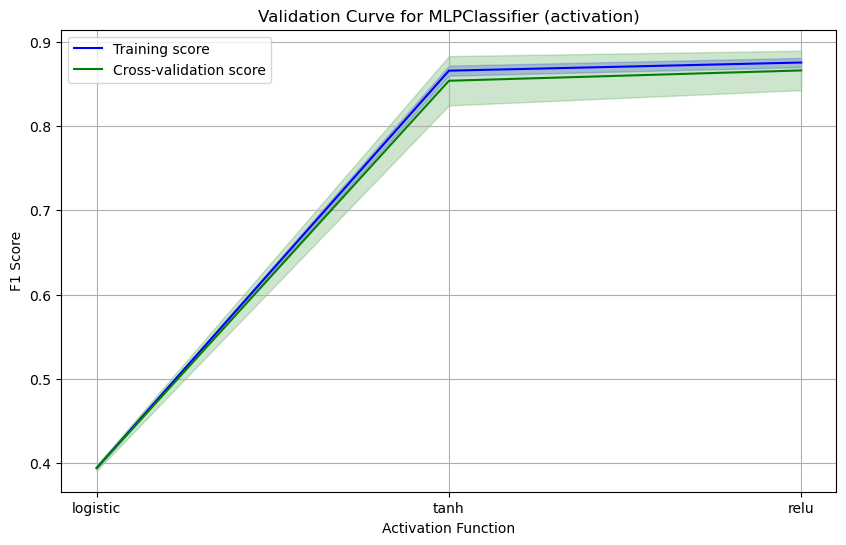

In [23]:
# Define the parameter range for activation
activation_range = ['logistic', 'tanh', 'relu']

# Create a scorer for F1 Score
f1_scorer = make_scorer(f1_score, average='weighted')

# Validation curve for activation
train_scores, valid_scores = validation_curve(
    MLPClassifier(solver='sgd', max_iter=4000, learning_rate='constant', alpha=0.1, hidden_layer_sizes=(100, 50), random_state=42, verbose=True),
    X_train, y_train,
    param_name='activation',
    param_range=activation_range,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(activation_range, train_mean, label='Training score', color='blue')
plt.plot(activation_range, valid_mean, label='Cross-validation score', color='green')
plt.fill_between(activation_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(activation_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='green')
plt.title('Validation Curve for MLPClassifier (activation)')
plt.xlabel('Activation Function')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilay

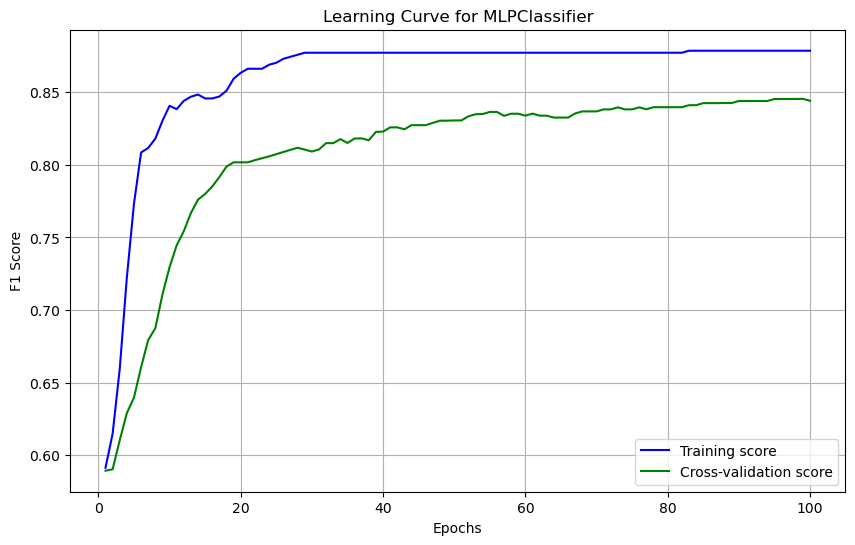

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

# Define the model with the tuned hyperparameters
mlp = MLPClassifier(solver='sgd', max_iter=1, learning_rate='constant', alpha=0.1,
                    hidden_layer_sizes=(100, 50), activation='relu', warm_start=True, random_state=42)

# Initialize lists to store scores
train_scores = []
cv_scores = []

# Define the number of epochs
epochs = np.arange(1, 101)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)

# Loop over the number of epochs
for epoch in epochs:
    mlp.max_iter = epoch  # Set the current number of epochs
    mlp.fit(X_train, y_train)  # Fit the model on the training data
    
    # Calculate training score
    train_score = f1_score(y_train, mlp.predict(X_train), average='weighted')
    train_scores.append(train_score)
    
    # Calculate cross-validation score
    cv_score = cross_val_score(mlp, X_train, y_train, cv=cv, scoring=f1_scorer).mean()
    cv_scores.append(cv_score)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_scores, label='Training score', color='blue')
plt.plot(epochs, cv_scores, label='Cross-validation score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Learning Curve for MLPClassifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilay

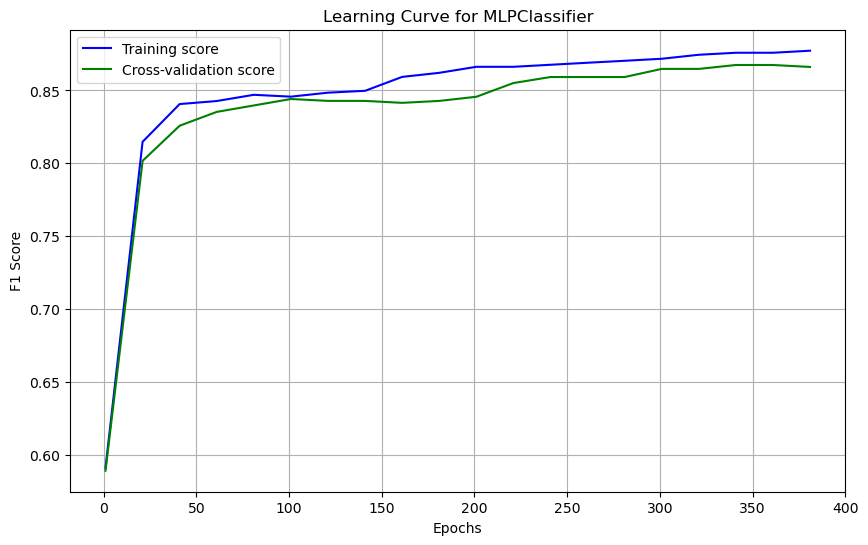

In [42]:
# Define the model with the tuned hyperparameters
mlp = MLPClassifier(solver='sgd', max_iter=2000, learning_rate='constant', alpha=0.1,
                    hidden_layer_sizes=(100, 50), activation='relu', random_state=42)

# Initialize lists to store scores
train_scores = []
cv_scores = []

# Define the number of epochs
epochs = np.arange(1, 401, 20)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)

# Create a scorer for F1 Score
f1_scorer = make_scorer(f1_score, average='weighted')

# Loop over the number of epochs
for epoch in epochs:
    mlp.set_params(max_iter=epoch)  # Set the current number of epochs
    mlp.fit(X_train, y_train)  # Fit the model on the training data
    
    # Calculate training score
    train_score = f1_score(y_train, mlp.predict(X_train), average='weighted')
    train_scores.append(train_score)
    
    # Calculate cross-validation score
    cv_score = cross_val_score(mlp, X_train, y_train, cv=cv, scoring=f1_scorer).mean()
    cv_scores.append(cv_score)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_scores, label='Training score', color='blue')
plt.plot(epochs, cv_scores, label='Cross-validation score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Learning Curve for MLPClassifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()


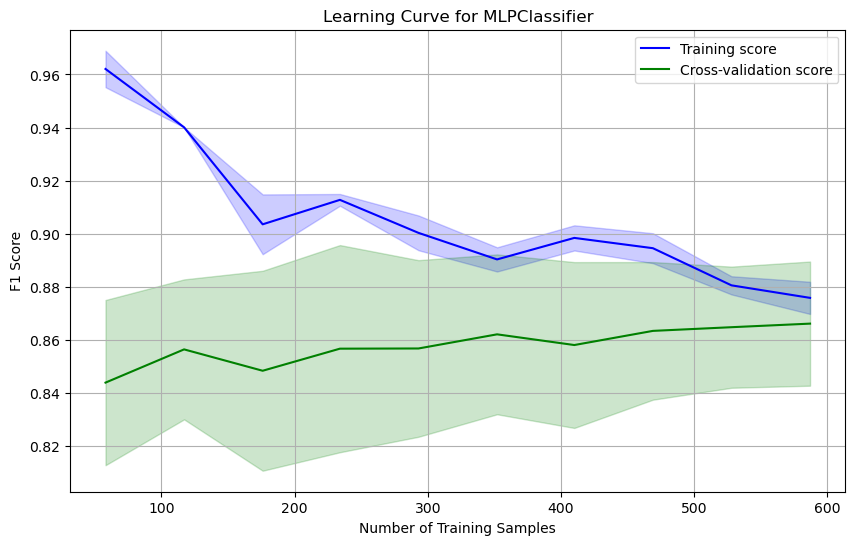

In [44]:
from sklearn.model_selection import learning_curve

# Define the model with the tuned hyperparameters
mlp = MLPClassifier(solver='sgd', max_iter=4000, learning_rate='constant', alpha=0.1,
                    hidden_layer_sizes=(100, 50), activation='relu', random_state=42)

# Create a scorer for F1 Score
f1_scorer = make_scorer(f1_score, average='weighted')

# Calculate learning curve
train_sizes, train_scores, cv_scores = learning_curve(
    mlp, X_train, y_train, cv=5, scoring=f1_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
cv_mean = np.mean(cv_scores, axis=1)
cv_std = np.std(cv_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, cv_mean, label='Cross-validation score', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2, color='green')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Learning Curve for MLPClassifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Iteration 1, loss = 0.70314025
Iteration 2, loss = 0.70056240
Iteration 3, loss = 0.69663698
Iteration 4, loss = 0.69181945
Iteration 5, loss = 0.68667654
Iteration 6, loss = 0.68116969
Iteration 7, loss = 0.67568182
Iteration 8, loss = 0.67006222
Iteration 9, loss = 0.66441192
Iteration 10, loss = 0.65898123
Iteration 11, loss = 0.65337868
Iteration 12, loss = 0.64818041
Iteration 13, loss = 0.64279884
Iteration 14, loss = 0.63767952
Iteration 15, loss = 0.63262564
Iteration 16, loss = 0.62739389
Iteration 17, loss = 0.62256963
Iteration 18, loss = 0.61758318
Iteration 19, loss = 0.61281766
Iteration 20, loss = 0.60796290
Iteration 21, loss = 0.60318542
Iteration 22, loss = 0.59838421
Iteration 23, loss = 0.59380840
Iteration 24, loss = 0.58918119
Iteration 25, loss = 0.58451002
Iteration 26, loss = 0.57996844
Iteration 27, loss = 0.57545664
Iteration 28, loss = 0.57107190
Iteration 29, loss = 0.56667486
Iteration 30, loss = 0.56224536
Iteration 31, loss = 0.55790722
Iteration 32, los

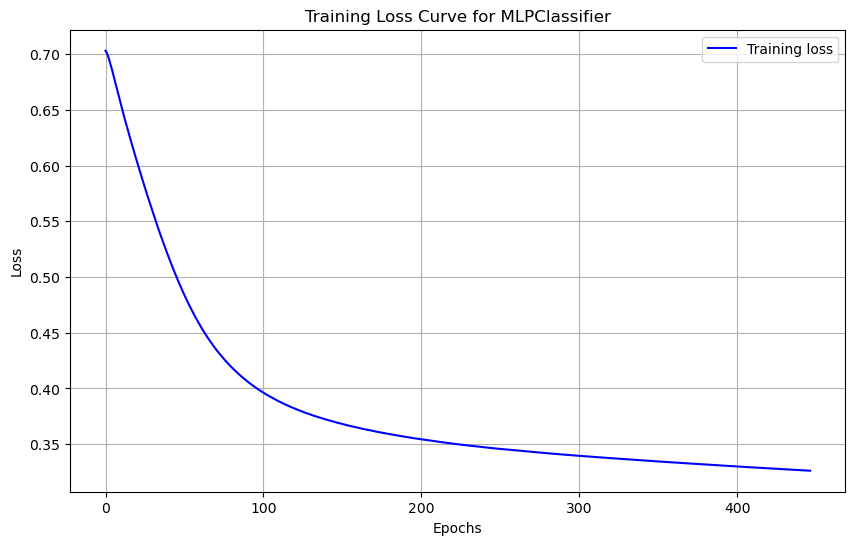

In [47]:
# Define the model with the tuned hyperparameters
mlp = MLPClassifier(solver='sgd', max_iter=2000, learning_rate='constant', alpha=0.1,
                    hidden_layer_sizes=(100, 50), activation='relu', random_state=42, verbose=True)

# Fit the model on the training data
mlp.fit(X_train, y_train)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_, label='Training loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve for MLPClassifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
# Define the model with the tuned hyperparameters
mlp = MLPClassifier(solver='sgd', learning_rate='constant', alpha=0.1,
                    hidden_layer_sizes=(100, 50), activation='relu', random_state=42, warm_start=True)

# Initialize lists to store scores and loss values
train_losses = []
cv_scores = []

# Define the number of epochs
epochs = 100

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)
f1_scorer = make_scorer(f1_score, average='weighted')

# Loop over the number of epochs
for epoch in range(1, epochs + 1):
    mlp.set_params(max_iter=epoch)  # Increment the number of epochs
    mlp.fit(X_train, y_train)  # Fit the model on the training data
    
    # Record the training loss
    train_losses.append(mlp.loss_)
    
    # Calculate the cross-validation score
    cv_score = cross_val_score(mlp, X_train, y_train, cv=cv, scoring=f1_scorer).mean()
    cv_scores.append(cv_score)

# Plot the training loss and cross-validation score
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training loss', color='blue')
plt.plot(range(1, epochs + 1), cv_scores, label='Cross-validation score', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss / F1 Score')
plt.title('Training Loss and Cross-Validation Score Curve for MLPClassifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()


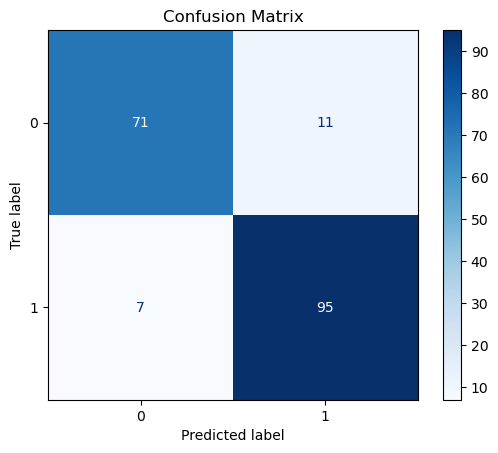

F1 Score: 0.90


In [78]:
mlp = MLPClassifier(solver='sgd', max_iter=2000, learning_rate='constant', alpha=0.1, hidden_layer_sizes=(100, 50), activation='relu', random_state=42)
mlp.fit(X_train, y_train)

# Predict the test set
y_pred = mlp.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Compute and display the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")